In [38]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from itertools import product

base_features = dict(
    concentration=[1, 10, 100, 1000],
    size=[100, 200],                  
    orientation=[0, 1],  
    tail_species=['tail1', 'tail2', 'tail3'], 
    polymer_species=['PO', 'PS'],
    polymer_density=[0, 1, 10]
)

long_df = pd.DataFrame(list(product(*base_features.values())), columns = base_features.keys())
np.random.seed(seed = 123456)
long_df['value'] = np.random.normal(100, 3, long_df.shape[0])

def modify_long_df(eval_statement, multiplier):
    long_df.loc[long_df.eval(eval_statement), 'value'] = long_df.loc[long_df.eval(eval_statement), 'value'] * multiplier
    
modify_long_df('polymer_species=="PS"', 1.4)
modify_long_df('tail_species=="tail3"', 1.1)
modify_long_df('polymer_species=="PS" and size==200', 0.8)
modify_long_df('polymer_species=="PS" and polymer_density==1', 1.2)
modify_long_df('polymer_density==10', 0.9)
modify_long_df('concentration==10', 1.2)
modify_long_df('concentration==100', 1.4)
modify_long_df('concentration==1000', 1.6)
long_df = long_df.convert_dtypes()
long_df['value'] = long_df['value'].round(2)
long_df

,concentration,size,orientation,tail_species,polymer_species,polymer_density,value
0,1,100,0,tail1,PO,0,101.41
1,1,100,0,tail1,PO,1,99.15
2,1,100,0,tail1,PO,10,85.93
3,1,100,0,tail1,PS,0,135.23
4,1,100,0,tail1,PS,1,174.11
...,...,...,...,...,...,...,...
283,1000,200,1,tail3,PO,1,178.22
284,1000,200,1,tail3,PO,10,163.31
285,1000,200,1,tail3,PS,0,189.49
286,1000,200,1,tail3,PS,1,242.13


In [50]:
from typing import List, Tuple
from sortedcollections import OrderedSet

def long_to_heat_df(long_df, feature_ordering: Tuple[List[int], List[int]] = None):
    
    # overall methodology:
    # 1. Gather unique labels for rows/cols
    # 2. Create label ordering for rows/cols, which defines the labels for each row in the plot
    # 3. Create mapping from plot indices to long_df row indices
    # 4. Combine with long_df label info
    
    # if feature ordering is specified, then take first half of features as rows, then other half as columns
    if not feature_ordering:
        # record index names, assume all columns are index except label
        index_columns = list(OrderedSet(long_df.columns) - {'value'})
        row_features = index_columns[:int(len(index_columns)/2)]
        col_features = index_columns[int(len(index_columns)/2):]
    else:
        row_features, col_features = feature_ordering

    long_df = long_df.copy()
    long_df[row_features + col_features] = long_df[row_features + col_features].astype('string')
    
    # record unique label of each feature
    row_sections = {x: list(long_df[x].unique()) for x in row_features}
    col_sections = {x: list(long_df[x].unique()) for x in col_features}
    
    # create every combination of row/col label
    row_labels = list(product(*row_sections.values()))
    col_labels = list(product(*col_sections.values()))
    
    # create list of tuples of labels, defines the label for each row/col
    # also include integer index, needed for merging with labels
    row_labels = [x+(i,) for i,x in enumerate(row_labels)]
    col_labels = [x+(i,) for i,x in enumerate(col_labels)]

    # create mapping between the row label, the row index in the plot, and the original row index from long_df
    row_labels_df = long_df[row_features].copy()
    row_labels_df['long_df_index'] = range(row_labels_df.shape[0]) # add integer index
    row_mapping_df = pd.DataFrame(row_labels, columns=row_features + ['row_plot_index'])
    row_mapping_df = row_mapping_df.merge(row_labels_df)

    # same but for col label, col index in plot, and the original row index in long_df
    col_labels_df = long_df[col_features].copy()
    col_labels_df['long_df_index'] = range(col_labels_df.shape[0])
    col_mapping_df = pd.DataFrame(col_labels, columns=col_features + ['col_plot_index'])
    col_mapping_df = col_mapping_df.merge(col_labels_df)
    
    # combine with long_df values
    label_mapping_df = long_df[['value']].copy()
    label_mapping_df['long_df_index'] = range(label_mapping_df.shape[0])
    label_mapping_df = col_mapping_df.merge(row_mapping_df).merge(label_mapping_df)
    
    # label_mapping_df is in "long" form with columns like index_name, index_name, index_name, label
    # convert to wide form for plotting as a heatmap
    heat_df = pd.pivot_table(label_mapping_df, columns='col_plot_index', index='row_plot_index', values='value')
    
    label_mapping_df['hovertext'] = 'Value: ' + label_mapping_df['value'].astype('string')
    for col in row_features + col_features:
        label_mapping_df['hovertext'] += '<br>' + col + ': ' + label_mapping_df[col]
    
    hovertext_df = pd.pivot_table(label_mapping_df, columns='col_plot_index', index='row_plot_index', values='hovertext', aggfunc='first')
    
    return heat_df, label_mapping_df, hovertext_df, row_features, col_features

feature_ordering = [['polymer_species', 'polymer_density', 'orientation'], ['concentration', 'size', 'tail_species']]
heat_df, label_mapping_df, hovertext_df, row_features, col_features = long_to_heat_df(long_df, feature_ordering)
heat_df.iloc[:5, :5]

col_plot_index,0,1,2,3,4
row_plot_index,,,,,
0,101.41,100.36,112.38,101.07,100.83
1,100.83,101.21,105.56,96.49,99.77
2,99.15,96.87,107.67,97.98,98.58
3,96.74,101.73,112.79,99.32,96.44
4,85.93,87.67,95.91,85.2,89.96


In [51]:
def _label_font_size(sizes = [9,10,12,14]):
    for font_size in sizes:
        yield font_size
    yield font_size

def get_label_info(features, label_mapping_df, row_label = True):
    
    groupby_col, mean_col = 'row_plot_index', 'col_plot_index'
    if row_label:
        groupby_col, mean_col = 'col_plot_index', 'row_plot_index'
    
    label_font_size = _label_font_size()
    
    label_info_df = list()
    features = features[::-1] # go in backwards order, from lowest to highest levels
    section_size = 1
    for i, feature in enumerate(features):
        new_df = label_mapping_df[[*features[i:], 'col_plot_index', 'row_plot_index']].groupby([*features[i:], groupby_col])[mean_col].mean().reset_index()
        new_df.rename(columns={mean_col: 'label_coordinate', feature: 'label'}, inplace=True)
        
        new_df[['feature', 'feature_level', 'section_size', 'label_font_size']] = [feature, i, section_size, next(label_font_size)]
        new_df = new_df[['feature', 'label', 'feature_level', 'label_coordinate', 'section_size', 'label_font_size']].drop_duplicates()

        label_info_df.append(new_df)
        section_size = section_size * new_df['label'].nunique()
        
    return pd.concat(label_info_df).reset_index(drop=True)

In [54]:
def dimensional_stacking(heat_df, hovertext_df, row_labels_df, col_labels_df, height = None, width = None, **heatmap_kwargs):
    
    dx_label, dy_label = 1/20, 1/12
    
    fig = go.Figure()
    fig.add_trace(go.Heatmap(z=heat_df, hovertext=hovertext_df, hovertemplate='%{hovertext}', name='', hoverongaps = False, **heatmap_kwargs))
    
    # rough attempt to dynamically specify height/width
    height = height or 200+heat_df.shape[0]*30
    width = width or 100+heat_df.shape[1]*30

    fig.update_layout(yaxis=dict(visible=False), xaxis=dict(visible=False), height=height, width=width, margin=dict(l=150, r=20, t=100, b=150))
        
    for i, feature_info in row_labels_df[['feature', 'feature_level']].drop_duplicates().iterrows():
        fig.add_annotation(x=-dx_label*feature_info['feature_level'], y=0, 
                           showarrow=False, text=feature_info['feature'], textangle=-90, font=dict(size=14), 
                           align='right', valign='bottom', 
                           xanchor='right', yanchor='top', 
                           xref='paper', yref='paper')
        
    for _, row in row_labels_df.iterrows():
        _, _, feature_level, label_coordinate, section_size, label_font_size = row
        x = -feature_level*dx_label
        
        fig.add_annotation(x=x, y=label_coordinate, 
                           showarrow=False, text=str(row['label']), textangle=-90, font=dict(size=10),
                           align='center', valign='bottom',
                           xanchor='right', yanchor='bottom',
                           xref='paper')
        
        if row['feature_level'] != 0:
            fig.add_shape(type='line', x0=x, x1=x, y0=label_coordinate-section_size/2 + 0.1, y1=label_coordinate+section_size/2 - 0.1,
                          line=dict(color='Black', width=0.5), 
                          xref='paper', yref='y')
        
        
    for i, feature_info in col_labels_df[['feature', 'feature_level']].drop_duplicates().iterrows():
        fig.add_annotation(x=0, y=1+(feature_info['feature_level'])*dy_label, 
                           showarrow=False, text=feature_info['feature'], font=dict(size=14), 
                           align='right', valign='bottom', 
                           xanchor='right', yanchor='bottom', 
                           xref='paper', yref='paper')

    for _, row in col_labels_df.iterrows():
        _, _, feature_level, label_coordinate, section_size, label_font_size = row
        y = 1+feature_level*dy_label
        
        fig.add_annotation(x=label_coordinate, y=y, 
                           showarrow=False, text=str(row['label']), font=dict(size=label_font_size),
                           align='center', valign='bottom', 
                           xanchor='center', yanchor='bottom',
                           yref='paper')
        
        if row['feature_level'] != 0:
            fig.add_shape(type='line', x0=label_coordinate-section_size/2 + 0.1, x1=label_coordinate+section_size/2 - 0.1, y0=y, y1=y,
                          line=dict(color='Black', width=0.5), 
                          xref='x', yref='paper')
        
    return fig

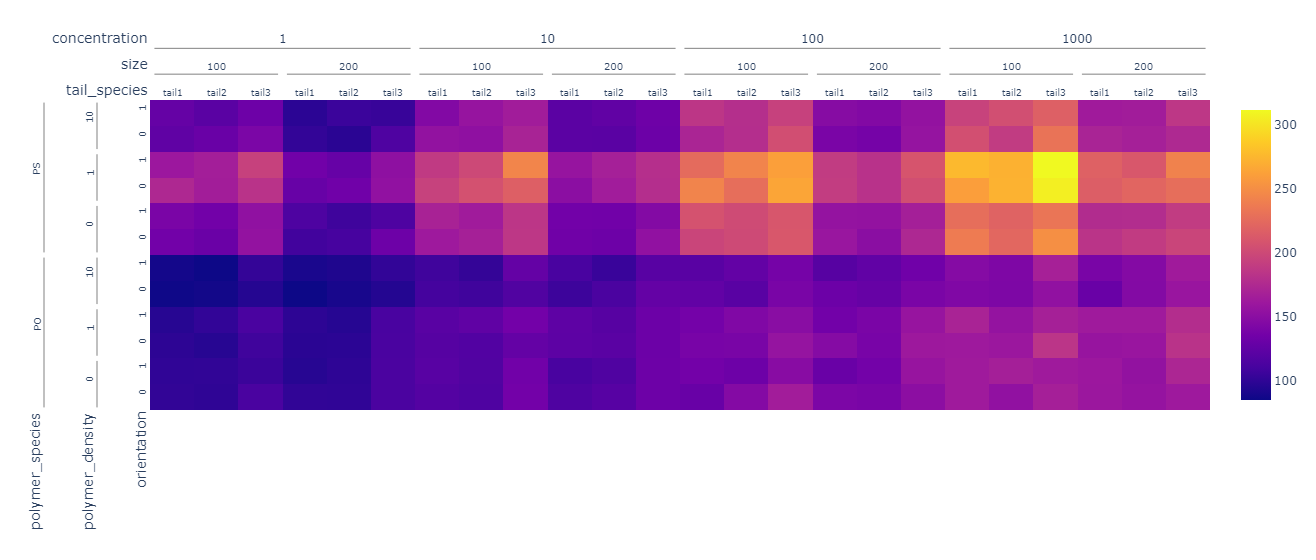

In [55]:
feature_ordering = [['polymer_species', 'polymer_density', 'orientation'], ['concentration', 'size', 'tail_species']]
heat_df, label_mapping_df, hovertext_df, row_features, col_features = long_to_heat_df(long_df, feature_ordering)

row_labels_df = get_label_info(row_features, label_mapping_df, True)
col_labels_df = get_label_info(col_features, label_mapping_df, False)

fig = dimensional_stacking(heat_df, hovertext_df, row_labels_df, col_labels_df)
fig.show()